# Hands-On MIP Modeling: O4A Hands-On Session

In this notebook we will take a look at a simple assignment/scheduling problem.
1. We will use the libraries `pyomo` and `highspy` to create a first formulation and solve some instances.
2. We will then apply some tricks to improve the model, making it easier to solve.
3. Finally, we create a completely different formulation of the same assignment problem and see that this one is superior.

## Setup (Google Colab)

Run this cell to install the required packages. If you're running locally, you can skip this cell.

In [ ]:
# Install required packages (run this cell in Google Colab)
!pip install pyomo highspy matplotlib pydantic --quiet

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [ ]:
# Imports
import pyomo.environ as pyo
from pyomo.contrib.appsi.solvers.highs import Highs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pydantic import BaseModel, Field, computed_field, model_validator, field_validator
import random
import time

---
# Part 1: The Business Problem

## Problem Description

There are $N$ **workers** and $K$ **tasks**.

- Every task $j$ has a fixed start time $\alpha_j$ and end time $\omega_{j}$.
- Tasks are assigned to workers.
- Any worker $i$ could do any task $j$.
- Multiple tasks can be assigned to a single worker. But:
- If a worker has at least one task assigned to them, they start a shift:
- Workers have a minimum and a maximum shift length $D_{min}$ and $D_{max}$.
- All tasks assigned to a worker must be within this shift and they may not overlap.

**Objective:**
Minimize the sum of all shift lengths while fulfilling all tasks!

## Domain Model

Let's define our data structures first. We use `pydantic` BaseModels, which work very well together with modeling in `pyomo`.

In [ ]:
# Define Problem data structures

class Task(BaseModel, frozen=True):
    """Represents a task with an id, start time and end time."""
    id: int
    start: int
    end: int


class Problem(BaseModel):
    """Represents the problem instance."""
    tasks: list[Task] = Field(description="tasks to be assigned to workers")
    N: int = Field(description="Number of workers N", ge=1)
    D_min: int = Field(description="Minimum shift length", ge=0)
    D_max: int = Field(description="Maximum shift length", ge=0)

In [ ]:
# Define Solution and helper functions
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!    You can skip this Code      !!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



def get_overlapping_tasks(tasks: list[Task]) -> list[tuple[Task, Task]]:
    """
    Returns all pairs of tasks that overlap.
    Two tasks overlap if one doesn't end before the other starts.
    """
    result = []
    for i, task1 in enumerate(tasks):
        for task2 in tasks[i + 1:]:
            if task1.end <= task2.start or task2.end <= task1.start:
                continue  # in this case, task1 and task2 do not overlap
            result.append((task1, task2))
    return result


class WorkerShift(BaseModel):
    """Represents a shift for a single worker."""
    start: int
    end: int
    tasks: list[Task]

    @model_validator(mode="after")
    def check_feasible(self) -> "WorkerShift":
        overlapping_tasks = get_overlapping_tasks(self.tasks)
        if overlapping_tasks:
            raise ValueError("Worker Shift contains overlapping tasks")
        if self.start > self.end:
            raise ValueError("Start time after end time for WorkerShift")
        if self.tasks:
            earliest_task_start = min(t.start for t in self.tasks)
            if earliest_task_start < self.start:
                raise ValueError("At least one task starts before WorkerShift")
            latest_task_end = max(t.end for t in self.tasks)
            if latest_task_end > self.end:
                raise ValueError("At least one task ends after WorkerShift")
        return self


class Solution(BaseModel, frozen=True):
    """Represents a solution to the problem."""
    problem: Problem
    shifts: list[WorkerShift] = Field(description="assigns every task from problem.tasks to a worker")

    @computed_field
    def cost(self) -> int:
        return sum(s.end - s.start for s in self.shifts)

    @model_validator(mode="after")
    def check_feasible(self) -> "Solution":
        tasks_in_shifts = []
        for shift in self.shifts:
            length = shift.end - shift.start
            if length > self.problem.D_max:
                raise ValueError("One WorkerShift longer than D_max")
            if 0 < length < self.problem.D_min:
                raise ValueError("One WorkerShift shorter than D_min but not 0")
            tasks_in_shifts.extend(shift.tasks)
        if set(tasks_in_shifts) != set(self.problem.tasks):
            raise ValueError("Inconsistency detected between tasks in shifts and tasks in problem")
        return self


def create_solution_from(task_assignment: list[list[Task]], problem: Problem) -> Solution:
    """Create a Solution object from a task assignment."""
    D_min = problem.D_min
    worker_shifts = []
    for tasks in task_assignment:
        if not tasks:
            continue
        earliest_task_start = min(t.start for t in tasks)
        latest_task_end = max(t.end for t in tasks)
        shift_start = min(earliest_task_start, 24 - D_min)
        shift_end = max(latest_task_end, shift_start + D_min)
        worker_shifts.append(WorkerShift(start=shift_start, end=shift_end, tasks=tasks))
    return Solution(problem=problem, shifts=worker_shifts)

In [ ]:
# Define a plotting function for solutions
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!    You can skip this Code      !!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def plot_solution(solution: Solution, title: str = None):
    """Plot the solution showing workers and their assigned tasks."""
    num_shifts = len(solution.shifts)
    if num_shifts == 0:
        print("No shifts to display")
        return

    fig, ax = plt.subplots(figsize=(14, max(2, (num_shifts + 1) * 0.8)))
    bar_height = 0.5

    for shift_idx, shift in enumerate(solution.shifts):
        y_pos = shift_idx

        # Draw shift background (grey transparent bar)
        ax.barh(
            y_pos, shift.end - shift.start, left=shift.start,
            height=bar_height, color="grey", alpha=0.3,
            edgecolor="grey", linewidth=1,
        )

        # Draw task bars (blue with task id)
        for task in shift.tasks:
            ax.barh(
                y_pos, task.end - task.start, left=task.start,
                height=bar_height, color="steelblue",
                edgecolor="darkblue", linewidth=1,
            )
            ax.text(
                (task.start + task.end) / 2, y_pos, str(task.id),
                ha="center", va="center", color="white",
                fontweight="bold", fontsize=10,
            )

    ax.set_xlim(0, 24)
    ax.set_ylim(-0.5, num_shifts - 0.5)
    ax.set_xticks(range(25))
    ax.set_yticks(range(num_shifts))
    ax.set_yticklabels([f"Worker {i}" for i in range(num_shifts)])
    ax.invert_yaxis()
    ax.set_xlabel("Hour")
    ax.set_ylabel("Worker")
    ax.set_title(title or f"Solution (Total Cost: {solution.cost} hours)")
    ax.grid(axis="x", alpha=0.3)

    shift_patch = mpatches.Patch(color="grey", alpha=0.3, label="Shift")
    task_patch = mpatches.Patch(color="steelblue", label="Task")
    ax.legend(handles=[shift_patch, task_patch], loc="upper right")

    plt.tight_layout()
    plt.show()

In [ ]:
# Define utility function for creating instances
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!    You can skip this Code      !!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def create_random_instance(
    num_tasks: int = 100,
    num_workers: int = 40,
    D_min: int = 7,
    D_max: int = 10,
    seed: int = 123,
) -> Problem:
    """Create a random problem instance."""
    random.seed(seed)

    tasks = []
    for i in range(num_tasks):
        start = random.randint(0, 22)
        duration = random.randint(1, min(3, 24 - start))
        end = start + duration
        tasks.append(Task(id=i, start=start, end=end))

    return Problem(
        tasks=tasks,
        N=num_workers,
        D_min=D_min,
        D_max=D_max,
    )

## Baby Example

Let us take a look at a very simple first instance of our problem.

In [ ]:
# Baby example
N = 3  # number of workers
tasks = [
    Task(id=0, start=10, end=12),  # Task 0: 10:00 - 12:00
    Task(id=1, start=11, end=13),  # Task 1: 11:00 - 13:00
    Task(id=2, start=20, end=21),  # Task 2: 20:00 - 21:00
]
D_min = 7
D_max = 10

baby_problem = Problem(tasks=tasks, N=N, D_min=D_min, D_max=D_max)
print(f"Problem: {N} workers, {len(tasks)} tasks")
print(f"Shift constraints: D_min = {D_min}h, D_max = {D_max}h")
for t in tasks:
    print(f"  Task {t.id}: {t.start}:00 - {t.end}:00")

Problem: 3 workers, 3 tasks
Shift constraints: D_min = 7h, D_max = 10h
  Task 0: 10:00 - 12:00
  Task 1: 11:00 - 13:00
  Task 2: 20:00 - 21:00


## Observations on the Example

- Task 0 and 1 cannot be assigned to the same worker. They overlap.
- Task 0 and 2 cannot be assigned to the same worker. They would create a shift length of 11 hours (10:00 - 21:00), which is greater than $D_{max} = 10$.
- Possible solution:
  - Task 0 $\rightarrow$ Worker 0
  - Task 1 $\rightarrow$ Worker 1  
  - Task 2 $\rightarrow$ Worker 1
  - No tasks assigned to Worker 2
  - Schedule:
    - Worker 0 shift: 10:00 - 17:00 (minimum shift length applies)
    - Worker 1 shift: 11:00 - 21:00
  - Total cost: 7 + 10 + 0 = 17 hours

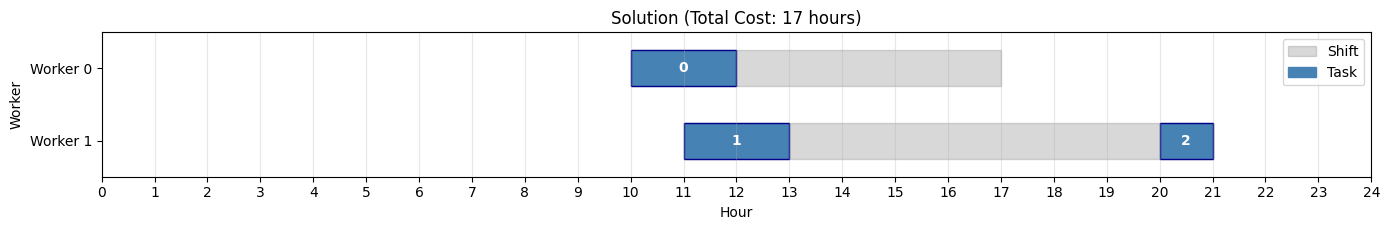

In [ ]:
# Visualize solution
task0, task1, task2 = baby_problem.tasks
solution = create_solution_from(task_assignment=[[task0], [task1, task2]], problem=baby_problem)
plot_solution(solution)

---
# Part 2: Modeling the Problem

Think about:
- How to model assignment of tasks to workers?
- How to ensure overlapping tasks are not assigned to the same worker?
- How to model the shift length of a worker?
  - No task: shift length = 0
  - At least one task: between $D_{min}$ and $D_{max}$

**Your tools: Create variables, constraints, objective function!**

---
# The Assignment Formulation

## Input
- Number of workers $N$
- $K$ tasks with start time $\alpha_j$ and end time $\omega_j$ each
- $D_{min}$: minimum shift length
- $D_{max}$: maximum shift length

## Variables

| Variable | Domain | Description |
|----------|--------|-------------|
| $y_i$ | $\{0,1\}$ | $y_i = 1$ $\iff$ worker $i$ will have a shift |
| $x_{i,j}$ | $\{0,1\}$ | $x_{i,j} = 1$ $\iff$ worker $i$ will do task $j$ |
| $s_i$ | $\mathbb{N}$ | shift start time of worker $i$ |
| $t_i$ | $\mathbb{N}$ | shift end time of worker $i$ |

## Going back to the example

- $x_{1,1} = 1$, because worker 1 does task 1.
- $y_2 = 0$, because worker 2 does not work.
- $s_0 = 10$, $t_0 = 17$. Worker 0 starts at 10:00 and ends their shift at 17:00.

## Constraints

### 1. Every task needs to be served
$$\sum_{i=0}^{N-1} x_{i,j} = 1 \quad \forall \text{ tasks } j$$

### 2. No overlapping tasks for same worker
$$x_{i,j_1} + x_{i,j_2} \leq 1 \quad \forall \text{ workers } i, \forall \text{ overlapping task pairs } (j_1, j_2)$$

### 3. Minimum shift length
$$s_i + y_i \cdot D_{min} \leq t_i \quad \forall \text{ workers } i$$

### 4. Maximum shift length
$$t_i \leq s_i + y_i \cdot D_{max} \quad \forall \text{ workers } i$$

**Note:** 
- If $y_i = 0$, we get $s_i \leq t_i$ and $t_i \leq s_i$, so $s_i = t_i$. 
- If $y_i = 1$, we get $s_i + D_{min} \leq t_i \leq s_i + D_{max}$, which leads to $D_{min} \leq t_i - s_i \leq D_{max}$.

### 5. Task end before shift end
$$x_{i,j} \cdot \omega_j \leq t_i \quad \forall \text{ workers } i, \forall \text{ tasks } j$$

### 6. Task start after shift start (using Big-M)
$$s_i \leq x_{i,j} \cdot \alpha_j + (1 - x_{i,j}) \cdot M \quad \forall \text{ workers } i, \forall \text{ tasks } j$$

**Note:** 
- This constraint should have no effect if $x_{i,j} = 0$. This is why we use **big-M** here.
- Without the term $(1 - x_{i,j}) \cdot M $, $s_i$ would be forced to be $0$ if any $x_{i,j}$ is $0$.
## Objective Function
$$\min \sum_{i=1}^{N} (t_i - s_i)$$

## Pyomo Implementation

In [ ]:
M = 1000  # Big-M constant


def create_model_instance(problem: Problem) -> pyo.ConcreteModel:
    """Create the basic assignment model."""
    overlapping_task_pairs = get_overlapping_tasks(problem.tasks)

    # Create Model
    m = pyo.ConcreteModel("Worker Task Assignment")
    
    # Define Sets
    m.workers = pyo.RangeSet(0, problem.N-1)
    m.tasks = pyo.Set(initialize=problem.tasks)
    m.overlapping_tasks = pyo.Set(initialize=overlapping_task_pairs)

    # Define Parameters
    @m.Param()
    def DMIN(m):
        return problem.D_min

    @m.Param()
    def DMAX(m):
        return problem.D_max

    # Define Variables
    m.y = pyo.Var(m.workers, domain=pyo.Binary)  # Worker has shift?
    m.x = pyo.Var(m.workers * m.tasks, domain=pyo.Binary)  # Worker i does task j?
    m.s = pyo.Var(m.workers, domain=pyo.NonNegativeIntegers)  # Shift start
    m.t = pyo.Var(m.workers, domain=pyo.NonNegativeIntegers)  # Shift end

    # Constraint 1: Every task needs to be served
    @m.Constraint(m.tasks)
    def fulfill_all_tasks(m, j):
        return pyo.quicksum(m.x[i, j] for i in m.workers) == 1

    # Constraint 2: No overlapping tasks for same worker
    @m.Constraint(m.workers, m.overlapping_tasks)
    def no_overlapping_tasks(m, i, j1, j2):
        return m.x[i, j1] + m.x[i, j2] <= 1

    # Constraint 3: Minimum shift length
    @m.Constraint(m.workers)
    def minimum_shift_length(m, i):
        return m.s[i] + m.y[i] * m.DMIN <= m.t[i]

    # Constraint 4: Maximum shift length
    @m.Constraint(m.workers)
    def maximum_shift_length(m, i):
        return m.t[i] <= m.s[i] + m.y[i] * m.DMAX

    # Constraint 5: Task start after shift start (Big-M)
    @m.Constraint(m.workers, m.tasks)
    def task_start_after_shift_start(m, i, j):
        return m.s[i] <= m.x[i, j] * j.start + (1 - m.x[i, j]) * M

    # Constraint 6: Task end before shift end
    @m.Constraint(m.workers, m.tasks)
    def task_end_before_shift_end(m, i, j):
        return m.x[i, j] * j.end <= m.t[i]

    # Objective: Minimize total shift time
    @m.Objective(sense=pyo.minimize)
    def total_costs(m):
        return pyo.quicksum(m.t[i] - m.s[i] for i in m.workers)

    return m

In [ ]:
def solve_assignment_model(m: pyo.ConcreteModel, problem: Problem, verbose: bool = True, time_limit: float = None) -> Solution:
    """Solve the assignment model and return a Solution object."""
    solver = Highs()
    solver.config.stream_solver = verbose
    solver.highs_options["log_to_console"] = verbose
    if time_limit is not None:
        solver.highs_options["time_limit"] = time_limit  # in seconds
        
    _ = solver.solve(m)

    task_assignment = [[] for _ in range(problem.N)]

    for (i, task), value in m.x.items():
        if value.value > 0.5:
            task_assignment[i].append(task)

    return create_solution_from(task_assignment=task_assignment, problem=problem)

## Solving the Baby Example

In [ ]:
# Create and solve the baby example
model = create_model_instance(baby_problem)
solution = solve_assignment_model(model, baby_problem, verbose=False)

print(f"\nSolution found!")
print(f"Total cost: {solution.cost} hours")
print(f"Number of workers used: {len(solution.shifts)}")


Solution found!
Total cost: 17 hours
Number of workers used: 2


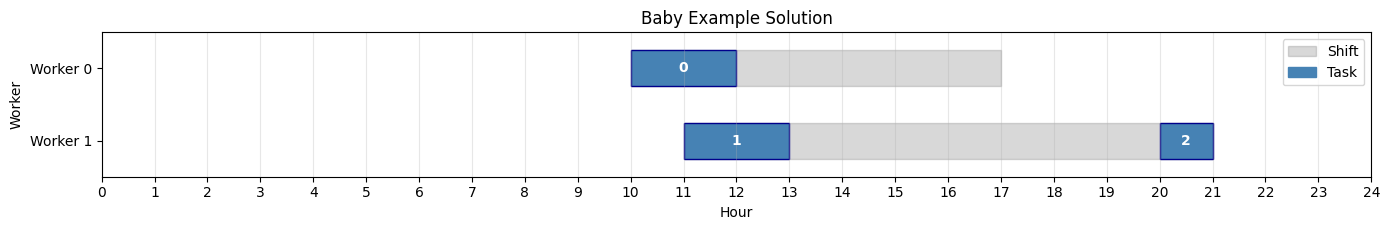

In [ ]:
plot_solution(solution, "Baby Example Solution")

## Testing with a small Instance (12 tasks, 6 workers)

Problem: 6 workers, 12 tasks
Number of overlapping task pairs: 5

Solved in 2.91 seconds
Total cost: 31 hours


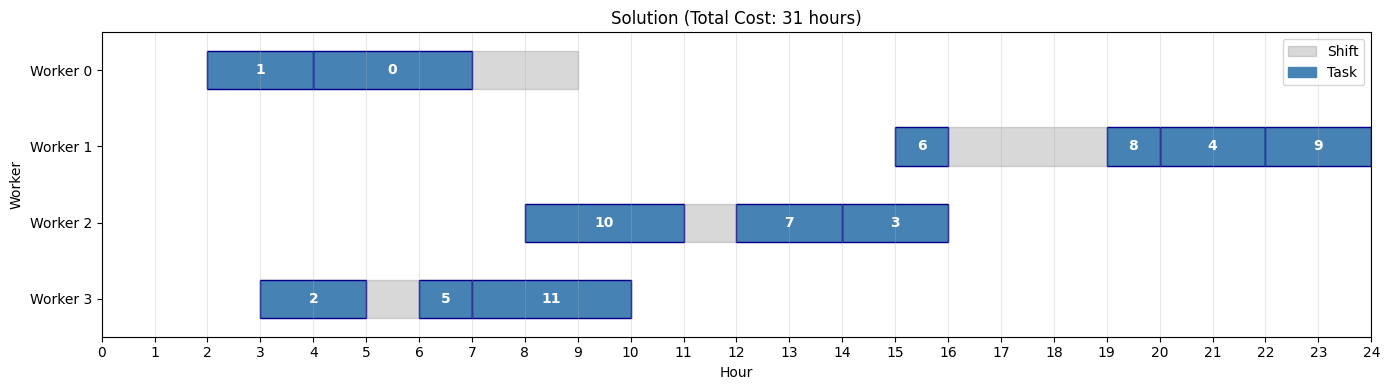

In [ ]:
problem_12_6 = create_random_instance(num_tasks=12, num_workers=6, seed=-1)

print(f"Problem: {problem_12_6.N} workers, {len(problem_12_6.tasks)} tasks")
print(f"Number of overlapping task pairs: {len(get_overlapping_tasks(problem_12_6.tasks))}")

start_time = time.time()
model = create_model_instance(problem_12_6)
solution = solve_assignment_model(model, problem_12_6, verbose=True, time_limit=20)
elapsed = time.time() - start_time

print(f"\nSolved in {elapsed:.2f} seconds")
print(f"Total cost: {solution.cost} hours")
plot_solution(solution)

## Testing with a Larger Instance (25 tasks, 10 workers)

Problem: 10 workers, 25 tasks
Number of overlapping task pairs: 38
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.

Solved in 20.04 seconds
Total cost: 71 hours


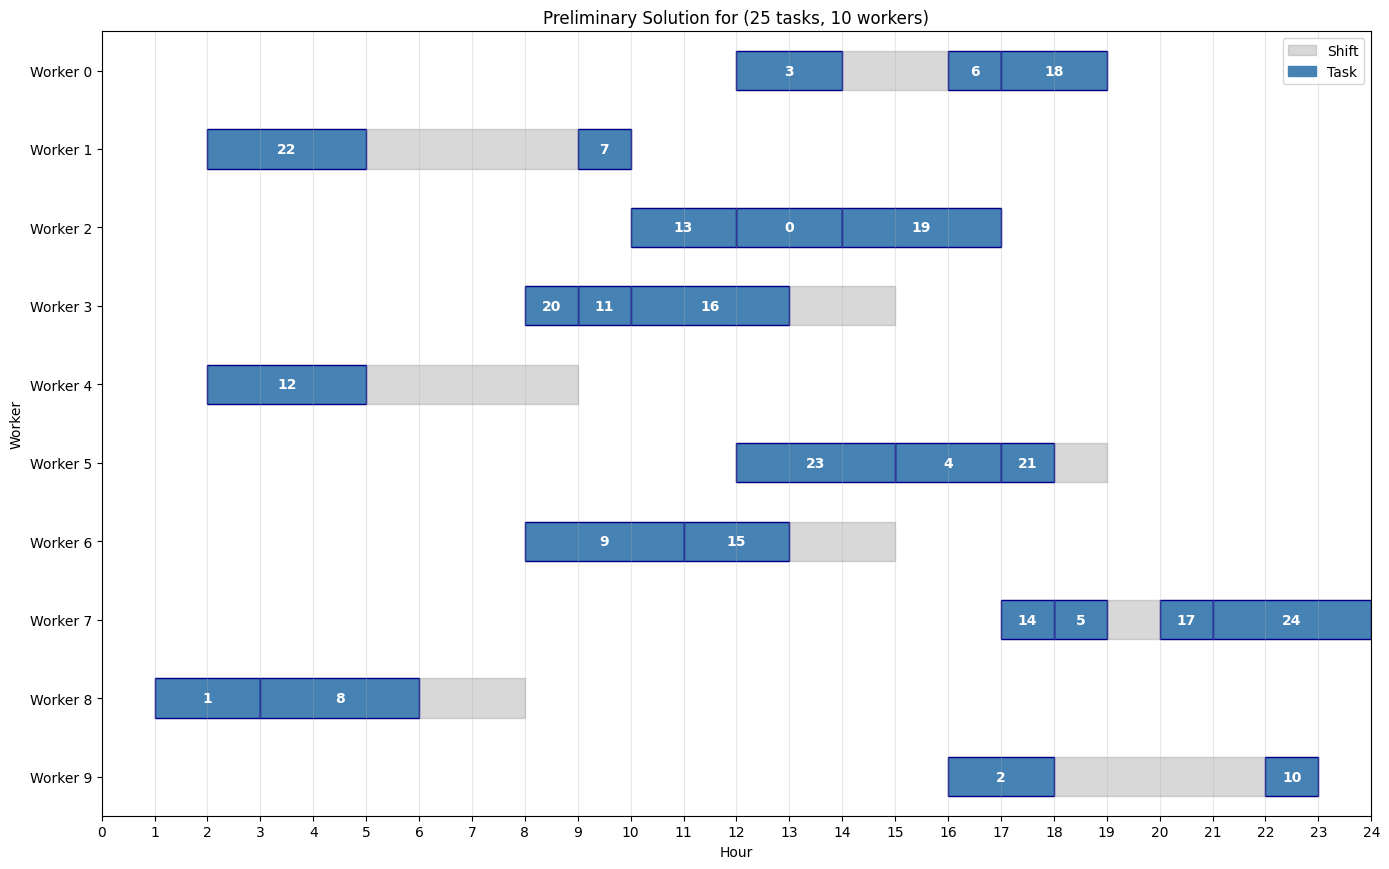

In [ ]:
# Create a medium-sized instance
problem_25_10 = create_random_instance(num_tasks=25, num_workers=10, seed=0)

print(f"Problem: {problem_25_10.N} workers, {len(problem_25_10.tasks)} tasks")
print(f"Number of overlapping task pairs: {len(get_overlapping_tasks(problem_25_10.tasks))}")

start_time = time.time()
model_25 = create_model_instance(problem_25_10)
solution_25 = solve_assignment_model(model_25, problem_25_10, verbose=True, time_limit=20)
elapsed = time.time() - start_time

print(f"\nSolved in {elapsed:.2f} seconds")
print(f"Total cost: {solution_25.cost} hours")
plot_solution(solution_25, "Preliminary Solution for (25 tasks, 10 workers)")

---
# Problem Analysis

Let's analyze what makes this problem hard:

1. **Many variables and constraints** - Print the model to see!
2. **Many overlap constraints** - Scales with $O(K^2)$
3. **Symmetry is a problem** - Permuting workers gives equivalent solutions
4. **Big-M is bad** - Creates weak LP relaxations

In [ ]:
# Analyze the model size
def analyze_model(m: pyo.ConcreteModel, problem: Problem):
    num_binary = len(list(m.y)) + len(list(m.x))
    num_integer = len(list(m.s)) + len(list(m.t))

    # Count constraints by type
    constraint_counts = {}
    total_constraints = 0
    for constraint in m.component_objects(pyo.Constraint, active=True):
        count = sum(1 for _ in constraint)
        constraint_counts[constraint.name] = count
        total_constraints += count

    print("Model Analysis:")
    print(f"  Binary variables (y, x): {num_binary}")
    print(f"  Integer variables (s, t): {num_integer}")
    print(f"  Total constraints: {total_constraints}")
    print("  Constraints by type:")
    for name, count in constraint_counts.items():
        print(f"    - {name}: {count}")

analyze_model(model_25, problem_25_10)

Model Analysis:
  Binary variables (y, x): 260
  Integer variables (s, t): 20
  Total constraints: 925
  Constraints by type:
    - fulfill_all_tasks: 25
    - no_overlapping_tasks: 380
    - minimum_shift_length: 10
    - maximum_shift_length: 10
    - task_start_after_shift_start: 250
    - task_end_before_shift_end: 250


---
# Part 3: Model Improvements

## Improvement 1: Tighter Big-M

Original constraint:
$$s_i \leq x_{i,j} \cdot \alpha_j + (1 - x_{i,j}) \cdot M$$

**Why is a large M bad?** In the linear relaxation, the optimal solution can exploit slack. The bigger the M, the more slack variable $s_i$ gets even when $x_{i,j}$ is almost 1.

**Solution:** Make M as tight as possible! The maximum value $s_i$ can take is $24 - D_{min}$ (latest possible shift start).

$$M = 24 - D_{min}$$

## Improvement 2: Symmetry Breaking

**Problem:** Different solutions that are essentially the same (just permuting worker assignments).

For instance (25,10), a single solution can have up to $10!$ duplicate solutions by permuting workers!

**Solution:** Order workers by shift start time (or some other criterion).

$$s_{i-1}  \leq s_i \quad \forall i > 1$$

## Improvement 3: Cutting Planes (Clique Constraints)

**Idea:** Reduce the solution space of the LP relaxation without reducing the MILP solution space.

**Original overlap constraint:** One constraint per overlapping task *pair*.

**Better:** For each hour, at most one task active at that hour can be assigned to a worker.

$$\sum_{j : \text{task } j \text{ active at hour } h} x_{i,j} \leq 1 \quad \forall i, \forall h \in [0, 23]$$

This gives us only 24 constraint groups instead of $O(K^2)$!

## Improvement 4: Variable Bounds

Add explicit bounds on shift start and end times. These bounds are outside of the constraints and help the solver in the presolve phase.
- $s_i \in [0, 24 - D_{min}]$
- $t_i \in [D_{min}, 24]$

In [ ]:
def get_overlapping_tasks_per_hour(tasks: list[Task]) -> list[list[Task]]:
    """
    For each hour (0-23), returns the list of tasks active during that hour.
    """
    result = []
    for hour in range(24):
        active_tasks = []
        for task in tasks:
            if task.start <= hour < task.end:
                active_tasks.append(task)
        result.append(active_tasks)
    return result


def create_improved_model(problem: Problem) -> pyo.ConcreteModel:
    """Create the improved assignment model."""
    # Improvement: Use per-hour overlapping tasks instead of pairs
    overlapping_task_per_hour = get_overlapping_tasks_per_hour(problem.tasks)
    
    # Improvement: Tight Big-M
    M_tight = 24 - problem.D_min
    
    # Create Model
    m = pyo.ConcreteModel("Worker Task Assignment - Improved")
    
    # Define Sets
    m.workers = pyo.RangeSet(0, problem.N-1)
    m.tasks = pyo.Set(initialize=problem.tasks)
    m.hours = pyo.RangeSet(0, 23)  # For hourly overlap constraints

    # Define Parameters
    @m.Param()
    def DMIN(m):
        return problem.D_min

    @m.Param()
    def DMAX(m):
        return problem.D_max

    # Define Variables with bounds (Improvement 4)
    m.y = pyo.Var(m.workers, domain=pyo.Binary)
    m.x = pyo.Var(m.workers * m.tasks, domain=pyo.Binary)
    m.s = pyo.Var(m.workers, domain=pyo.NonNegativeIntegers, 
                  bounds=(0, 24 - problem.D_min))
    m.t = pyo.Var(m.workers, domain=pyo.NonNegativeIntegers, 
                  bounds=(problem.D_min, 24))

    # Constraint: Every task needs to be served
    @m.Constraint(m.tasks)
    def fulfill_all_tasks(m, j):
        return pyo.quicksum(m.x[i, j] for i in m.workers) == 1

    # Improvement 3: Clique constraints instead of pairwise
    @m.Constraint(m.workers, m.hours)
    def no_overlapping_tasks(m, i, h):
        active_tasks = overlapping_task_per_hour[h]
        if len(active_tasks) <= 1:
            return pyo.Constraint.Skip
        return pyo.quicksum(m.x[i, j] for j in active_tasks) <= 1

    # Constraint: Minimum shift length
    @m.Constraint(m.workers)
    def minimum_shift_length(m, i):
        return m.s[i] + m.y[i] * m.DMIN <= m.t[i]

    # Constraint: Maximum shift length
    @m.Constraint(m.workers)
    def maximum_shift_length(m, i):
        return m.t[i] <= m.s[i] + m.y[i] * m.DMAX

    # Constraint: Task start after shift start (with tight M)
    @m.Constraint(m.workers, m.tasks)
    def task_start_after_shift_start(m, i, j):
        return m.s[i] <= m.x[i, j] * j.start + (1 - m.x[i, j]) * M_tight

    # Constraint: Task end before shift end
    @m.Constraint(m.workers, m.tasks)
    def task_end_before_shift_end(m, i, j):
        return m.x[i, j] * j.end <= m.t[i]

    # Improvement 2: Symmetry breaking
    @m.Constraint(m.workers)
    def symmetry_breaker(m, i):
        if i == 0:
            return pyo.Constraint.Skip
        return m.s[i - 1] <= m.s[i]

    # Objective: Minimize total shift time
    @m.Objective(sense=pyo.minimize)
    def total_costs(m):
        return pyo.quicksum(m.t[i] - m.s[i] for i in m.workers)

    return m

## Testing the Improved Model

In [ ]:
# Compare basic vs improved model on (25, 10)
print("\n" + "=" * 60)
print("IMPROVED MODEL (25 tasks, 10 workers)")
print("=" * 60)

start_time = time.time()
model_improved = create_improved_model(problem_25_10)
solution_improved = solve_assignment_model(model_improved, problem_25_10, verbose=True, time_limit=20)
time_improved = time.time() - start_time

print(f"Time: {time_improved:.2f}s, Cost: {solution_improved.cost}")
analyze_model(model_improved, problem_25_10)



IMPROVED MODEL (25 tasks, 10 workers)
Time: 0.62s, Cost: 71
Model Analysis:
  Binary variables (y, x): 260
  Integer variables (s, t): 20
  Total constraints: 704
  Constraints by type:
    - fulfill_all_tasks: 25
    - no_overlapping_tasks: 150
    - minimum_shift_length: 10
    - maximum_shift_length: 10
    - task_start_after_shift_start: 250
    - task_end_before_shift_end: 250
    - symmetry_breaker: 9


In [ ]:
problem_50_20 = create_random_instance(num_tasks=50, num_workers=20, seed=1)

In [ ]:
# Test improved model on bigger instance (50, 20)
print("IMPROVED MODEL (50 tasks, 20 workers)")
print("=" * 60)

start_time = time.time()
model_50_improved = create_improved_model(problem_50_20)
solution_50_improved = solve_assignment_model(model_50_improved, problem_50_20, verbose=True, time_limit=20)
elapsed = time.time() - start_time

print(f"\nSolved in {elapsed:.2f} seconds")
print(f"Total cost: {solution_50_improved.cost} hours")

IMPROVED MODEL (50 tasks, 20 workers)
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.

Solved in 20.10 seconds
Total cost: 139 hours


## The Scaling Problem

Even with improvements, the model still struggles with larger instances. Why?

**Variable count:** Scales with $O(N \cdot K)$

**Constraint count:** Also scales with $O(N \cdot K)$

Can we do better?

---

# Part 4: A Different Perspective

## Introduction to Minimum Cost Flow

A **minimum cost flow** problem consists of:
- A directed graph with nodes and arcs
- One **source** node with a certain supply
- One **sink** node with a demand equal to the supply
- Each arc has a **capacity** (max flow that can pass)
- Each arc has a **cost** (incurred per unit of flow)

**Goal:** Move all flow from source to sink with minimum total cost.

### LP Formulation

**Variables:** $f_e \geq 0$ for each arc $e$

**Flow Conservation:**
$$\sum_{e \text{ outgoing from } v} f_e - \sum_{e \text{ incoming to } v} f_e = \text{supply}(v)$$

**Capacity:**
$$f_e \leq \text{capacity}(e)$$

**Objective:**
$$\min \sum_e c_e \cdot f_e$$

### The big benefit
The constraint matrix is **totally unimodular**. This means the LP solution found by simplex is guaranteed to be integer!

These problems are **very easy to solve**.

---

## Formulating Our Problem as a Flow

**Motivation:** Think about flow units as workers. We have as many flow units as workers.

Depending on how the flow (worker) travels through the network (their day) shows us which worker should be assigned to which task.

### The Network Structure

1. **Source:** All workers start here (supply = N)
2. **Sink:** All workers end here (demand = N)
3. **Workflow nodes:** For each possible (shift_start, current_time) pair

![image](https://github.com/jpjj/O4A-Hands-On-Modeling/blob/main/assets/graph2.png?raw=true)

### The Arcs

1. **Source to Workflow:** Worker decides when to start their shift
2. **Wait arcs:** Worker waits one hour without doing a task
3. **Task arcs:** Worker performs a task (jumps from task.start to task.end)
4. **Workflow to Sink:** Worker ends their shift (pays the cost!)
5. **Skip arc:** Worker doesn't work at all (source directly to sink)

![image](https://github.com/jpjj/O4A-Hands-On-Modeling/blob/main/assets/graph6.png?raw=true)

### Costs

- **Workflow to Sink:** $\text{cost} = \text{current time} - \text{shift start}$ (the shift length!)
- **Task arcs:** Large negative cost (incentive to do tasks)
- **All other arcs:** Zero cost

### Task Fulfillment Constraint

For each task, the sum of flows through all arcs representing that task must be $\leq 1$.

![image](https://github.com/jpjj/O4A-Hands-On-Modeling/blob/main/assets/graph10.png?raw=true)

(Note: This breaks total unimodularity, but these clique constraints behave nicely!)

In [ ]:
# Node and Arc classes for the flow model
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!    You can skip this Code      !!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

class WorkflowNode(BaseModel, frozen=True):
    """A node in the workflow graph representing (shift_start, current_time)."""
    start: int = Field(description="The shift start time", ge=0)
    time: int = Field(description="The current time", ge=0)


class Source(BaseModel, frozen=True):
    """The source node."""
    pass


class Sink(BaseModel, frozen=True):
    """The sink node."""
    pass


# Type alias for all node types
Node = WorkflowNode | Source | Sink


class Source2WorkflowArc(BaseModel, frozen=True):
    """Arc from source to a workflow node (worker starts shift)."""
    start: Source
    end: WorkflowNode

    @field_validator("end")
    @classmethod
    def check_layer_is_first(cls, v: WorkflowNode) -> WorkflowNode:
        if v.start != v.time:
            raise ValueError("Source must connect to first workflow node with start == time")
        return v


class TaskArc(BaseModel, frozen=True):
    """Arc representing a worker doing a task."""
    start: WorkflowNode
    end: WorkflowNode
    task: Task

    @model_validator(mode="after")
    def check_task_alignment(self) -> "TaskArc":
        if self.task.start != self.start.time:
            raise ValueError(f"Task start {self.task.start} != node time {self.start.time}")
        if self.task.end != self.end.time:
            raise ValueError(f"Task end {self.task.end} != node time {self.end.time}")
        return self


class WaitArc(BaseModel, frozen=True):
    """Arc representing a worker waiting one time unit."""
    start: WorkflowNode
    end: WorkflowNode

    @model_validator(mode="after")
    def check_wait_consistency(self) -> "WaitArc":
        if self.start.time >= self.end.time:
            raise ValueError(f"WaitArc must go forward in time")
        return self


class Workflow2SinkArc(BaseModel, frozen=True):
    """Arc from workflow node to sink (worker ends shift)."""
    start: WorkflowNode
    end: Sink


class SkipArc(BaseModel, frozen=True):
    """Arc from source directly to sink (worker doesn't work)."""
    start: Source = Source()
    end: Sink = Sink()


# Type alias for all arc types
Arc = Source2WorkflowArc | TaskArc | WaitArc | Workflow2SinkArc | SkipArc

In [ ]:
# Graph class and utilities
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!    You can skip this Code      !!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def flow_cost(arc: Arc, problem: Problem) -> float:
    """Calculate the cost of an arc."""
    if isinstance(arc, Workflow2SinkArc):
        return arc.start.time - arc.start.start  # Shift length
    elif isinstance(arc, TaskArc):
        return -(problem.D_max + 1)  # Large negative = incentive to do tasks
    else:
        return 0


def flow_supply(node: Node, problem: Problem) -> int:
    """Calculate the supply/demand of a node."""
    if isinstance(node, Source):
        return problem.N  # All workers start here
    elif isinstance(node, Sink):
        return -problem.N  # All workers end here
    else:
        return 0


class Graph(BaseModel):
    """The flow graph for the worker assignment problem."""
    problem: Problem
    nodes: list[Node] = Field(default_factory=list)
    arcs: list[Arc] = Field(default_factory=list)
    incoming_arcs: dict[Node, list[Arc]] = Field(default_factory=dict)
    outgoing_arcs: dict[Node, list[Arc]] = Field(default_factory=dict)
    task_to_arcs: dict[Task, list[TaskArc]] = Field(default_factory=dict)

    def add_node(self, node: Node):
        self.nodes.append(node)
        self.incoming_arcs[node] = []
        self.outgoing_arcs[node] = []

    def add_arc(self, arc: Arc):
        self.outgoing_arcs[arc.start].append(arc)
        self.incoming_arcs[arc.end].append(arc)
        self.arcs.append(arc)
        
        if isinstance(arc, TaskArc):
            if arc.task not in self.task_to_arcs:
                self.task_to_arcs[arc.task] = []
            self.task_to_arcs[arc.task].append(arc)


def create_graph(problem: Problem) -> Graph:
    """Create the flow graph for the problem."""
    graph = Graph(problem=problem)

    # Add source and sink
    source = Source()
    sink = Sink()
    graph.add_node(source)
    graph.add_node(sink)

    # Possible shift start times
    start_times = list(range(25 - problem.D_min))

    # Add workflow nodes
    for start in start_times:
        for time in range(start, 1 + min(24, start + problem.D_max)):
            graph.add_node(WorkflowNode(start=start, time=time))

    # Add skip arc (source -> sink directly)
    graph.add_arc(SkipArc())

    # Add source to workflow arcs
    for start in start_times:
        graph.add_arc(Source2WorkflowArc(
            start=source,
            end=WorkflowNode(start=start, time=start)
        ))

    # Add workflow arcs (wait and task)
    for start in start_times:
        filtered_tasks = [t for t in problem.tasks if t.start >= start]
        
        # Wait arcs
        for time in range(start, min(24, start + problem.D_max)):
            graph.add_arc(WaitArc(
                start=WorkflowNode(start=start, time=time),
                end=WorkflowNode(start=start, time=time + 1)
            ))

        # Task arcs
        for task in filtered_tasks:
            if task.end <= start + problem.D_max:
                graph.add_arc(TaskArc(
                    start=WorkflowNode(start=start, time=task.start),
                    end=WorkflowNode(start=start, time=task.end),
                    task=task
                ))

    # Add workflow to sink arcs (only at valid end times)
    for start in start_times:
        for time in range(start + problem.D_min, 1 + min(24, start + problem.D_max)):
            graph.add_arc(Workflow2SinkArc(
                start=WorkflowNode(start=start, time=time),
                end=Sink()
            ))

    return graph

## Creating the network flow model

In [ ]:
def create_flow_model(graph: Graph) -> pyo.ConcreteModel:
    """Create the flow model from the graph."""
    m = pyo.ConcreteModel("Worker Assignment - Flow Model")
    
    m.nodes = pyo.Set(initialize=graph.nodes)
    m.arcs = pyo.Set(initialize=graph.arcs)
    m.tasks = pyo.Set(initialize=graph.problem.tasks)

    # Variables: flow on each arc
    def get_bounds(m, e):
        if isinstance(e, TaskArc):
            return (0, 1)  # Each task done at most once per path
        return (0, graph.problem.N)

    m.f = pyo.Var(m.arcs, domain=pyo.NonNegativeIntegers, bounds=get_bounds)

    # Parameters
    m.cost = pyo.Param(m.arcs, initialize={e: flow_cost(e, graph.problem) for e in graph.arcs})
    m.supply = pyo.Param(m.nodes, initialize={v: flow_supply(v, graph.problem) for v in graph.nodes})

    # Objective: Minimize total cost
    @m.Objective(sense=pyo.minimize)
    def total_costs(m):
        return pyo.quicksum(m.cost[e] * m.f[e] for e in m.arcs)

    # Flow conservation constraint
    @m.Constraint(m.nodes)
    def flow_conservation(m, v):
        outgoing = pyo.quicksum(m.f[e] for e in graph.outgoing_arcs[v])
        incoming = pyo.quicksum(m.f[e] for e in graph.incoming_arcs[v])
        return outgoing - incoming == m.supply[v]

    # Task assignment constraint: each task at most once
    @m.Constraint(m.tasks)
    def task_assignment(m, task):
        return pyo.quicksum(m.f[e] for e in graph.task_to_arcs[task]) <= 1

    return m

In [ ]:
def solve_flow_model(m: pyo.ConcreteModel, graph: Graph, verbose: bool = True, time_limit: float = None) -> Solution:
    """Solve the flow model and extract the solution."""
    solver = Highs()
    solver.config.stream_solver = verbose
    solver.highs_options["log_to_console"] = verbose
    if time_limit is not None:
        solver.highs_options["time_limit"] = time_limit  # in seconds
    _ = solver.solve(m)

    # Extract paths (each path = one worker's assignment)

    activated_flows = {
        e: round(flow.value) for e, flow in m.f.items() if flow.value > 0.5
    }
    
    task_assignment = []
    while activated_flows:
        current_node = Source()
        tasks = []
        while not isinstance(current_node, Sink):
            # Find an outgoing arc with remaining flow
            arc = next(e for e in graph.outgoing_arcs[current_node] if e in activated_flows)
            activated_flows[arc] -= 1
            if activated_flows[arc] == 0:
                del activated_flows[arc]
            if isinstance(arc, TaskArc):
                tasks.append(arc.task)
            current_node = arc.end
        task_assignment.append(tasks)

    return create_solution_from(problem=graph.problem, task_assignment=task_assignment)

## Testing the Flow Model

FLOW MODEL - Baby Example
Graph: 194 nodes, 284 arcs
Cost: 17 hours


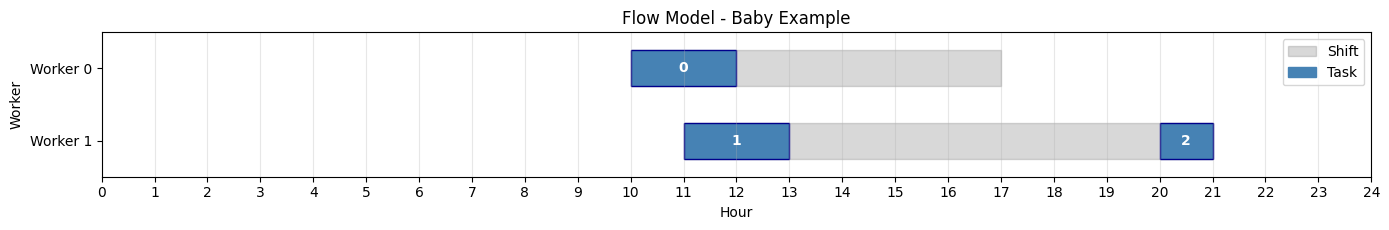

In [ ]:
# Test on baby example
print("FLOW MODEL - Baby Example")
print("=" * 60)

graph_baby = create_graph(baby_problem)
print(f"Graph: {len(graph_baby.nodes)} nodes, {len(graph_baby.arcs)} arcs")

flow_model_baby = create_flow_model(graph_baby)
flow_solution_baby = solve_flow_model(flow_model_baby, graph_baby, verbose=False)

print(f"Cost: {flow_solution_baby.cost} hours")
plot_solution(flow_solution_baby, "Flow Model - Baby Example")

In [ ]:
# Compare all three models on (50, 20)
print("=" * 70)
print("MODEL COMPARISON (50 tasks, 20 workers)")
print("=" * 70)

# Basic Model
print("\n[1] BASIC MODEL")
start_time = time.time()
model_basic_50 = create_model_instance(problem_50_20)
solution_basic_50 = solve_assignment_model(model_basic_50, problem_50_20, verbose=False, time_limit=20)
time_basic_50 = time.time() - start_time
print(f"    Time: {time_basic_50:.2f}s, Cost: {solution_basic_50.cost}")

# Improved Model
print("\n[2] IMPROVED MODEL")
start_time = time.time()
model_improved_50 = create_improved_model(problem_50_20)
solution_improved_50 = solve_assignment_model(model_improved_50, problem_50_20, verbose=False, time_limit=20)
time_improved_50 = time.time() - start_time
print(f"    Time: {time_improved_50:.2f}s, Cost: {solution_improved_50.cost}")

# Flow Model
print("\n[3] FLOW MODEL")
start_time = time.time()
graph_50 = create_graph(problem_50_20)
flow_model_50 = create_flow_model(graph_50)
flow_solution_50 = solve_flow_model(flow_model_50, graph_50, verbose=True, time_limit=20)
time_flow_50 = time.time() - start_time
print(f"    Time: {time_flow_50:.2f}s, Cost: {flow_solution_50.cost}")
print(f"    Graph: {len(graph_50.nodes)} nodes, {len(graph_50.arcs)} arcs")

print("\n" + "=" * 70)
print(f"Flow model is {time_basic_50/time_flow_50:.1f}x faster than basic model")
print(f"Flow model is {time_improved_50/time_flow_50:.1f}x faster than improved model")

MODEL COMPARISON (50 tasks, 20 workers)

[1] BASIC MODEL
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.
    Time: 20.30s, Cost: 139

[2] IMPROVED MODEL
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.
    Time: 20.11s, Cost: 139

[3] FLOW MODEL
    Time: 0.04s, Cost: 138
    Graph: 194 nodes, 577 arcs

Flow model is 493.0x faster than basic model
Flow model is 488.4x faster than improved model


In [ ]:
# Push it even further: (200, 80)
problem_200_80 = create_random_instance(num_tasks=200, num_workers=80)

print("FLOW MODEL (200 tasks, 80 workers)")
print("=" * 60)

start_time = time.time()
graph_200 = create_graph(problem_200_80)
print(f"Graph: {len(graph_200.nodes)} nodes, {len(graph_200.arcs)} arcs")

flow_model_200 = create_flow_model(graph_200)
flow_solution_200 = solve_flow_model(flow_model_200, graph_200, verbose=False)
elapsed = time.time() - start_time

print(f"\nSolved in {elapsed:.2f} seconds")
print(f"Total cost: {flow_solution_200.cost} hours")

FLOW MODEL (200 tasks, 80 workers)
Graph: 194 nodes, 1616 arcs

Solved in 0.28 seconds
Total cost: 434 hours


## Why is the Flow Model Better?

**Scaling Analysis:**

| Model | Variables | Constraints |
|---------|-------------|---------------|
| Basic | $O(N \cdot K)$ | $O(N \cdot K^2)$ |
| Improved | $O(N \cdot K)$ | $O(N \cdot K)$ |
| Flow | $O(D_{max} \cdot K)$ | $O(D_{max} \cdot K)$ |

**Key insight:** The flow model doesn't scale with the number of workers!

- Increasing workers: No effect on graph size
- Increasing tasks: Each task appears in at most $D_{max}$ workflow layers

**Additional benefits:**
1. Flow problems have well-understood structure
2. Near total unimodularity means quick branching
3. Easy to add complex cost functions

---
# Key Takeaways

## Summary

1. **Start simple**: Begin with a straightforward formulation to understand the problem

2. **Analyze and improve**:
   - Tighten Big-M constants
   - Add symmetry breaking constraints
   - Use cutting planes / clique constraints
   - Set variable bounds

3. **Think differently**: Sometimes a completely different formulation is the answer
   - The flow model turned an unfinished overnight calculation in into 10 seconds runtime (true story)!
   - Understanding problem structure enables better models

4. **Know your tools**: 
   - Pyomo for modeling
   - HiGHS for solving
   - Pydantic for creating classes
   - All these tools are free, powerful, and production-ready

## Further Topics

For even larger instances:
- Decomposition strategies (Benders, Dantzig-Wolfe)
- Metaheuristics (this is scheduling, after all!)
- Constraint Programming

Extensions to the problem:
- Finer time granularity (minutes instead of hours)
- More complex cost functions (overtime charges)
- Weekly scheduling with fairness constraints
- Handling infeasibility (maximize served tasks)

---
# Thank You!

Questions?

**Let's connect on linkedin:** [Jens-Peter Joost](https://www.linkedin.com/in/jens-peter-joost/)

**Resources:**
- [Pyomo Documentation](https://pyomo.readthedocs.io/)
- [HiGHS Solver](https://highs.dev/)
- [Network Flow Problems](https://en.wikipedia.org/wiki/Network_flow_problem)